In [1]:
#Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models
from cellpose.io import imread
from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd
import cv2 
from sklearn.preprocessing import PolynomialFeatures

#------------------------------------------------------
test_round = 1

# Get path to folders containing images
#Image_Directory = os.getcwd() + "\\20151218_E14_BM_mTF8additionals_4"
Image_Directory = "C:/Users/Claudia/Desktop/Master EPFL/machine learning/project_2" + "/test"  #Easier for me (Alexis) than finding of to get my path file nicely
# other folders: 
# \\20151218_E14_BM_mTF8additionals_4
# "//20151125_BM_mTF8additionals_3//Composite_mBM-mTF8"
print(Image_Directory)


# Create Lists containing datapath to all images of Cherry/ Ypet files
image_format = "tif"
cherry_condition = "TexasRed"
ypet_condition = "YFP"
Cherry_file = []
Ypet_file = []


# Walk through directory (call all files) and assign them to proper list
for root, dirs, files in os.walk(Image_Directory, topdown=False): # root = given in Input, dirs = folders, files= files
    for f in files:
        if f.endswith(image_format) and cherry_condition in f: 
            Cherry_file.append(os.path.join(root, f))
        elif f.endswith(image_format) and ypet_condition in f: 
            Ypet_file.append(os.path.join(root, f))

assert len(Cherry_file) == len(Ypet_file), f"There are {len(Cherry_file)} Cherry files and {len(Ypet_file)} Ypet files. The number has to be equal, check manually what's missing"

# Initialize lists containing cherry, ypet images
cherry_imgs = np.ndarray(test_round,dtype = np.ndarray)
ypet_imgs = np.ndarray(test_round,dtype = np.ndarray)
cherry_imgs_blurred = np.ndarray(test_round,dtype = np.ndarray)

# Read image (We donnot add it in for loop above to enable reading subset of image)
for i in range(test_round): #len(Cherry_file):
    cherry_imgs[i] = imread(Cherry_file[i])
    ypet_imgs[i] = imread(Ypet_file[i])
    #apply gaussian filter to reduce noise - cv2.GaussianBlur(source image, kernel size, sigmaX, sigmaY, borderType)
    #cherry_imgs_blurred[i] = cv2.GaussianBlur(cherry_imgs[i], (3, 3), 0) 
    #delete blurred parts of picture

    cherry_imgs_test = cherry_imgs[i]
    ypet_imgs_test = ypet_imgs[i]
    """    
    for x in range(0,2048,256):
        for y in range(0,2048,256):
            test = cherry_imgs_test[x:(x+257),y:(y+257)]
            print(cv2.Laplacian(test, 5).var())
            if cv2.Laplacian(test, 5).var() < 24000:
                print('schlaufe')
                cherry_imgs_test[x:(x+256),y:(y+256)] = 0
    """            
    cherry_imgs[i] = cherry_imgs_test[0:1000,1000:2049]
    ypet_imgs[i] = ypet_imgs_test[0:1000,1000:2049]
    
cherry_imgs = cherry_imgs.tolist()
ypet_imgs = ypet_imgs.tolist()

C:/Users/Claudia/Desktop/Master EPFL/machine learning/project_2/test


In [2]:
# Definine parameters for cellpose module using nuclei modus
# https://cellpose.readthedocs.io/en/latest/settings.html
channels = [0,0] # Corresponds to greyscale image
diameter = None # Model was trained on diameters of 17 pixels. None-> automated estimation of the diameter. Can be changed by hand later
flow_threshold = 0.4 # maximum allowed error of the flows for each mask, default = 0.4
gpu = False
model_type='nuclei'

# Set model
model = models.Cellpose(gpu, model_type)

# Nuclei segmentation of all images within cherry_imgs list
masks, flows, styles, diams = model.eval(cherry_imgs, diameter=diameter, channels=channels, flow_threshold=flow_threshold, do_3D=False)

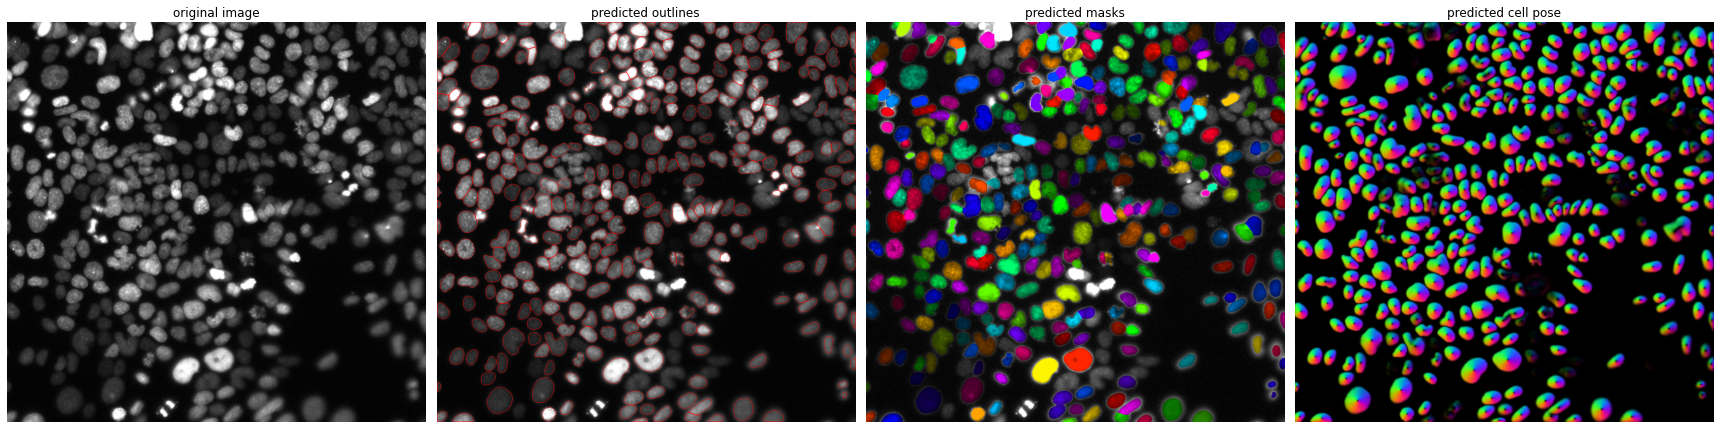

In [3]:
# Display results
image_i = 0
fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, cherry_imgs[image_i], masks[image_i], flows[image_i][0], channels)
plt.tight_layout()
plt.show()

In [4]:
# For future usage, save matrix
'''
mat.dump("my_matrix.dat")
mat2 = numpy.load("my_matrix.dat")'''

'\nmat.dump("my_matrix.dat")\nmat2 = numpy.load("my_matrix.dat")'

In [5]:
# Try with first image: masks[0]
masks_df =  pd.DataFrame(masks[0])   #Putting 1 here (when test_round = 2 completely changes the results)
ypet_df = pd.DataFrame(ypet_imgs[0])
range_s = np.arange(1,959)  #IMAGE SPECIFIC: cases where cell are big enough (sell last cell of the notebook)
columnname = ["" for i in range_s]
patch_size = [0 for i in range_s]
mean_intensity = [0 for i in range_s]
sum_intensity = [0 for i in range_s]
median_intensity = [0 for i in range_s]
variance_intensity = [0 for i in range_s]

assert masks_df.shape == ypet_df.shape, f"Shape of mask is {masks_df.shape} and the shape of ypet image is { ypet_df.shape}. The size has to be the same. Check if normalization is needed"

# Calculate patch size and corresponding ypet signal (mean) and store it into ypet_intensity
for i in range_s : # masks_df.nunique().size 
    columnname[i-1] = "patch_" + str(i)                     #We should not forgot that there is a -1 here.
    patch_size[i-1] = (masks_df == i).values.sum()
    mean_intensity[i-1] = np.nanmean(ypet_df[masks_df==i])
    #sum_intensity[i-1] = np.sum(ypet_df[masks_df==i])
    #median_intensity[i-1] = np.nanmedian(ypet_df[masks_df==i])
    #variance_intensity[i-1] = np.var(ypet_df[masks_df==i])

C:\Users\Claudia\AppData\Local\Temp/ipykernel_10536/2958556564.py:18: RuntimeWarning: Mean of empty slice
  mean_intensity[i-1] = np.nanmean(ypet_df[masks_df==i])


In [6]:
print(ypet_df.shape)

(1000, 1048)


In [7]:
ypet_intensity = pd.DataFrame(index=columnname)
ypet_intensity['patch_size'] = patch_size
ypet_intensity['mean_intensity'] = mean_intensity
#sklearn.preprocessing.PolynomialFeatures(degree=2, *, interaction_only=False, include_bias=True, order='C')

In [8]:
# Find relationship between nuclear size and expression level
# Apply ordinary least squares linear regression (For observational studies cross validation is not needed)
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold, cross_val_score
"""
#how many different training sets you want to have
k_folds = KFold(n_splits = 5)
#returns an array of the scores in the cross validation
scores = cross_val_score(clf, X, y, cv = k_folds)
"""
mod = smf.ols(formula='patch_size ~ mean_intensity', data= ypet_intensity[1:960])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             patch_size   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     6.248
Date:                Sun, 04 Dec 2022   Prob (F-statistic):             0.0129
Time:                        19:44:57   Log-Likelihood:                -2699.7
No. Observations:                 355   AIC:                             5403.
Df Residuals:                     353   BIC:                             5411.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1111.7946     50.991     21.

In [9]:
#cross validation with polynomial expansion
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [38]:
mean_intensity = np.array(mean_intensity).reshape(-1, 1)
patch_size = np.array(patch_size).reshape(-1, 1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 356 and the array at index 1 has size 958

In [37]:
x_train,x_test,y_train,y_test = train_test_split(patch_size,mean_intensity,train_size=0.8)

In [28]:
from sklearn.model_selection import train_test_split



#model to select
maxdegree = 5 #To define is the maximum degree of the polynomial
training_error = []
cross_validation_error = []


for d in range(1, maxdegree):
   # x_poly_train = bPolynomialFeatures(degree=d).fit_transform(x_train)
    x_poly_train = PolynomialFeatures(interaction_only=True)
    x_poly_train.fit_transform(x_train)
    print(x_poly_train)
    x_poly_test = PolynomialFeatures(degree=d).fit_transform(x_test)
    print(x_poly_test)
    lr = LinearRegression(fit_intercept=False)
    print(lr)
    model = model.fit(x_poly_train,y_train)
    print('step4')
    y_train_pred = model.predict(x_poly_train)
    print('step5')
    mse_train = mean_squared_error(y_train,y_train_pred)
    print('step6')
    cve = cross_validate(lr,x_poly_train,y_train,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    print('step7')
    training_error.append(mse_train)
    print('step8')
    cross_validation_error.append(np.mean(np.absolute(cve['test_score'])))
    print('step9')

#Make plot
fig,ax=plt.subplots(figsize=(6,6))
ax.plot(range(1,maxdegree),cross_validation_error)
ax.set_xlabel('Degree',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_title('MSE VS Degree',fontsize=25)

[array([[ 3665.73387097],
        [12927.57100298],
        [ 3806.46275753],
        [ 1806.87412587],
        [ 2468.84848485],
        [ 1636.96411483],
        [ 2176.40194489],
        [ 1413.51724138],
        [ 2655.0180072 ],
        [ 3263.51026393],
        [ 1241.56505576],
        [ 1426.31947801],
        [ 1182.68842975],
        [ 2206.51037851],
        [ 1754.55869958],
        [ 3156.28284024],
        [ 2282.11440329],
        [ 1490.80491803],
        [ 2000.42857143],
        [ 1393.81267218],
        [ 2446.55395072],
        [ 1095.44983462],
        [ 1089.94981273],
        [ 1345.907393  ],
        [ 2888.2724679 ],
        [ 1923.45727273],
        [ 1516.26753247],
        [ 2069.5794702 ],
        [ 1670.68239564],
        [ 1440.04815409],
        [ 2460.35303388],
        [ 1757.62191781],
        [ 1261.63793103],
        [ 1499.86975914],
        [ 1099.88837209],
        [ 1571.45902883],
        [ 1737.30395137],
        [ 1414.22165475],
        [ 22

C:\Users\Claudia\AppData\Local\Temp/ipykernel_10536/2618938564.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = np.array([X, y])


ValueError: Expected 2D array, got 1D array instead:
array=[   0  924 1081  417    0    0 1218    0  679 2056    0    0 1365  718
    0    0    0    0    0    0    0  986    0    0    0  925    0    0
    0  701  442    0    0 1961  693    0    0  743    0    0    0 1191
    0    0  773    0    0  524 1285 1288    0    0  625    0    0  682
    0    0    0  928    0    0    0 1026  629  142    0    0  134    0
    0    0  153    0    0 1234    0  343  624 1131  419    0    0    0
    0    0    0 1505    0    0 1102    0    0  684    0    0  663    0
 1910    0    0  892    0    0    0    0    0  597 1415    0 1653  736
    0    0 1002 1283 1095    0    0    0    0    0    0    0    0    0
 1614    0    0    0    0    0    0    0    0  906    0    0 1215    0
  377 1194 1509    0    0    0    0   53 2731    0    0    0    0    0
  922    0  981  833    0  882    0    0    0    0    0 1136    0  436
  186    0  799    0    0    0    0    0    0    0  537    0    0    0
    0    0    0  962    0    0    0 1059    0    0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
print(ypet_intensity[ypet_intensity['patch_size']!=0])  #To see until which should go range_s

In [16]:
X = np.arange(3).reshape(3, 1)
X

poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X)

array([[1., 0.],
       [1., 1.],
       [1., 2.]])

In [ ]:
ypet_intensity['patch_size'] = patch_size
ypet_intensity['mean_intensity'] = mean_intensity
#ypet_intensity['sum_intensity'] = sum_intensity
#ypet_intensity['median_intensity'] = median_intensity
#ypet_intensity['variance_intensity'] = variance_intensity


In [ ]:
#plot for better visualization
plt.plot(patch_size, mean_intensity, 'ro')
#plt.yscale("log")
#plt.xscale("log")
plt.show()

In [ ]:
np.sum(mean_intensity)

In [ ]:
## blurr detection of an image 
#laplacian
X = np.arange(20).reshape(3,1)
print(X)
"""
poly = PolynomialFeatures(2)
print(poly)
print(poly.fit_transform(X))
poly.fit_transform(X)
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X) """

In [ ]:
i=0
#calculate laplacian
x = cv2.Laplacian(img, cv2.CH_64F).var()

for x in range(0,2048,256):
    for i in range(0,2048,256):
        img = img[x:(x+256),y:(y+256)]
        if cv2.Laplacian(img, cv2.CH_64F).var() < 120:
            img[x:(x+256),y:(y+256)] 

In [ ]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])
x[0:2,2] = 0

x